# Using a Convolutional-Recurrent Neural Network to Predict the Effect of SNPs

Here we'll be trying to do the same thing as HAL, but using a neural network model trained earlier. We'll be using the convolutional-recurrent model from 2016-2-11.

In [70]:
%matplotlib inline
from keras.models import model_from_json
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils

import numpy as np
import matplotlib.pyplot as plt
import cPickle
from sklearn.metrics import r2_score

## Loading the Model

In [4]:
model = model_from_json(open('../data/convolutional-recurrent-model.json').read())

In [5]:
model.load_weights('../data/convolutional-recurrent.h5')

## Loading Data

In [7]:
import pandas as pd

In [8]:
table1 = pd.read_table('../data/mmc2.tsv')

In [9]:
table2 = pd.read_table('../data/mmc3.tsv')

In [11]:
table1.head()

id                                              EVENT  HETERO_COUNTS  \
0  11  chr10:102286311:102285953|102286156:-@chr10:10...              1   
1  12  chr10:102286311:102285953|102286156:-@chr10:10...              5   
2  17  chr10:102289263:102289123|102289137:-@chr10:10...              1   
3  20  chr10:102746732:102746444|102746506:-@chr10:10...            132   
4  26  chr10:102750193:102750300|102750420:+@chr10:10...              1   

   HETERO_PSI  HOMO_COUNTS  HOMO_PSI  \
0    0.020000            0       NaN   
1    0.022000            0       NaN   
2    0.040000            0       NaN   
3    0.884621           30  0.737667   
4    0.110000            0       NaN   

                                             MUT_SEQ  SD_DIST       SNP_ID  \
0  TGCAGGAAGAGTAGTATGTGACAGCTATTTGTCTTTCTGCCTCAGA...      203  rs182281336   
1  TGCAGGAAGAGTAGTATGTGACAGCTATTTGTCTTTCTGCCTCAGA...      203  rs116226794   
2  GCCCCTGCGACTTGAAGCCTTCGGAGCGGCTGGAGAGCGGGCTCGC...       14  rs145628277   
3  ATCCACTGCAAGTCGGTCGAGGAGATCTCGACGCTGGTGCAGAAGC...       62    rs2863095   
4  GGAGGCAGCCAAGAGAGTTTTCAGGATGCTAGTTCTTCTGCCTGGG...      120  rs147513679   

   SNP_POS        ...          MUT_EFFECT_SIZE  MAXENT_EFFECT_SIZE HOMO_PRED  \
0      386        ...                -0.853681                0.00  0.010493   
1      211        ...                 0.059698                0.00  0.025752   
2      208        ...                 0.416883                0.00  0.082848   
3      203        ...                -3.893001               -4.26  0.257667   
4      303        ...                 0.392244                0.00  0.111095   

  HETERO_PRED HETERO_DPSI HOMO_DPSI HETERO_DPSI_PRED HOMO_DPSI_PRED  \
0    0.017394   -0.004296       NaN        -0.006902      -0.013803   
1    0.025024   -0.002296       NaN         0.000728       0.001456   
2    0.069520   -0.016192       NaN         0.013328       0.026656   
3    0.601099   -0.059910 -0.206865        -0.343432      -0.686865   
4    0.094475    0.032145       NaN         0.016620       0.033240   

   LARGE_HETERO_EFFECT  LARGE_HOMO_EFFECT  
0                False              False  
1                False              False  
2                False              False  
3                 True               True  
4                False              False  

[5 rows x 28 columns]

In [12]:
table2.head()

Event  sample_num  \
0  chr10:100150839:100150628|100150767:-@chr10:10...          31   
1  chr10:100170715:100170370|100170696:-@chr10:10...          20   
2  chr10:100193848:100193697|100193740:-@chr10:10...         441   
3  chr10:100193848:100193697|100193740:-@chr10:10...         458   
4  chr10:101180562:101180370|101180381:-@chr10:10...         462   

   miso_posterior_mean    ci_low   ci_high       HAL  $\Delta$MAXENT  \
0             0.179032  0.044194  0.403871  0.017741           -4.97   
1             0.520000  0.103000  0.938500  0.890327           -0.68   
2             0.691655  0.329456  0.946236  0.177805            1.53   
3             0.211921  0.091048  0.373690  0.177805            1.53   
4             0.088745  0.037987  0.161169  0.001078           -1.67   

   $\Delta$MDD  $\Delta$MM  $\Delta$WMM  
0         -3.3       -2.34        -2.80  
1          0.7        0.86         3.95  
2          2.4        1.23         0.56  
3          2.4        1.23         0.56  
4         -3.2       -3.46        -2.98

In [13]:
table1.columns

Index([u'id', u'EVENT', u'HETERO_COUNTS', u'HETERO_PSI', u'HOMO_COUNTS',
       u'HOMO_PSI', u'MUT_SEQ', u'SD_DIST', u'SNP_ID', u'SNP_POS',
       u'WT_COUNTS', u'WT_PSI', u'WT_SEQ', u'GENE', u'SD1_MUT', u'SD2_MUT',
       u'SS_MUT', u'ALT_EXON_MUT', u'MUT_EFFECT_SIZE', u'MAXENT_EFFECT_SIZE',
       u'HOMO_PRED', u'HETERO_PRED', u'HETERO_DPSI', u'HOMO_DPSI',
       u'HETERO_DPSI_PRED', u'HOMO_DPSI_PRED', u'LARGE_HETERO_EFFECT',
       u'LARGE_HOMO_EFFECT'],
      dtype='object')

In [14]:
table2.columns

Index([u'Event', u'sample_num', u'miso_posterior_mean', u'ci_low', u'ci_high',
       u'HAL', u'$\Delta$MAXENT', u'$\Delta$MDD', u'$\Delta$MM',
       u'$\Delta$WMM'],
      dtype='object')

In [17]:
wt_seqs = table1.WT_SEQ

In [19]:
mut_seqs = table1.MUT_SEQ

In [20]:
wt_seqs_encoded = [nn_utils.seq_to_array(x) for x in wt_seqs]

In [21]:
mut_seqs_encoded = [nn_utils.seq_to_array(x) for x in mut_seqs]

In [22]:
wt_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), wt_seqs_encoded)

In [23]:
mut_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), mut_seqs_encoded)

## Using the NN Model to Predict dPSI

In [25]:
model.predict(wt_seqs_encoded[0])

array([[ 0.11642532]])

In [26]:
model.predict(mut_seqs_encoded[0])

array([[ 0.1162951]])

In [27]:
table1.HOMO_DPSI_PRED[0]

-0.013803373999999998

In [28]:
model_dpsi_pred = [model.predict(m) - model.predict(w) for m, w in zip(mut_seqs_encoded, wt_seqs_encoded)]

In [35]:
model_dpsi_pred = [x[0][0] for x in model_dpsi_pred]

In [41]:
hal_pred = []
model_pred = []
for h, m in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred):
    if h!=None and h>=-1 and h<=1:
        hal_pred.append(h)
        model_pred.append(m)

In [42]:
r2_score(hal_pred, model_pred)

-0.24388649479394875

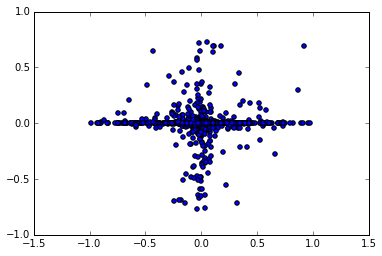

In [43]:
plt.scatter(hal_pred, model_pred)

In [48]:
hal_pred_2 = []
model_pred_2 = []
actual = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)

In [50]:
r2_score(actual, model_pred_2)

-0.34619367305376181

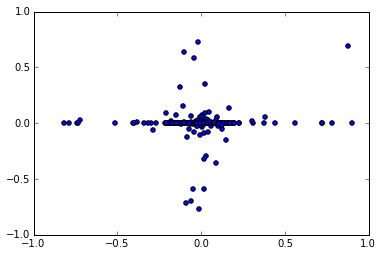

In [51]:
plt.scatter(actual, model_pred_2)

This is pretty bad. Let's compare this to how HAL does.

In [56]:
r2_score(actual, hal_pred_2)

-0.13802471148011586

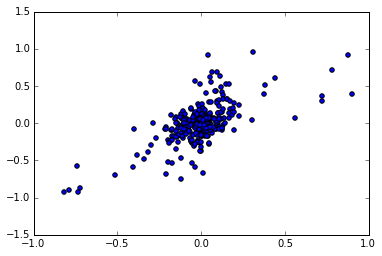

In [53]:
plt.scatter(actual, hal_pred_2)

So it seems that the neural network model generalizes poorly. Part of the reason could be that it's bad at dealing with longer sequences since it was only trained with sequences of length 25. Let's see how well it does when it's trained with actual genomic sequences as discovered by SUPPA.

## Training Model on Genomic Sequences

We're going to train the same model on genomic sequences now. The sequences were sourced from the same source as 2016-2-11, which is from SUPPA.

In [57]:
data = cPickle.load(open('../data/genomic_alt_5_gtex.pkl'))

In [59]:
genomic_exons = [c[1] for c in data]
genomic_exons_encoded = [nn_utils.seq_to_array(s) for s in genomic_exons]
actual = [c[2] for c in data]
new_actual = []
new_g = []
for a, g in zip(actual, genomic_exons_encoded):
    if a!=None and a!=0 and a!=-1 and len(g)<400:
        new_actual.append(a)
        new_g.append(g)

In [60]:
max_len = max([len(x) for x in new_g])
new_g2 = map(lambda x: np.rollaxis(sequence.pad_sequences(np.rollaxis(x, 1), max_len), 1), new_g)
new_g2 = np.dstack(new_g2)
new_g2 = np.rollaxis(new_g2, 2)

In [61]:
from sklearn.cross_validation import train_test_split

G_train, G_test, P_train, P_test = train_test_split(new_g2, new_actual, test_size=0.2, random_state=0)

In [63]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model.fit(G_train, P_train,
          nb_epoch=10,
          batch_size=500,
          show_accuracy=True,
          validation_data=(G_test, P_test),
          callbacks=[early_stopping])

Train on 9480 samples, validate on 2370 samples
Epoch 1/10
9480/9480 [==============================] - 179s - loss: 0.8749 - acc: 1.0000 - val_loss: 0.7318 - val_acc: 1.0000
Epoch 2/10
9480/9480 [==============================] - 182s - loss: 0.7114 - acc: 1.0000 - val_loss: 0.7008 - val_acc: 1.0000
Epoch 3/10
9480/9480 [==============================] - 177s - loss: 0.6980 - acc: 1.0000 - val_loss: 0.6962 - val_acc: 1.0000
Epoch 4/10
9480/9480 [==============================] - 174s - loss: 0.6942 - acc: 1.0000 - val_loss: 0.6944 - val_acc: 1.0000
Epoch 5/10
9480/9480 [==============================] - 175s - loss: 0.6925 - acc: 1.0000 - val_loss: 0.6928 - val_acc: 1.0000
Epoch 6/10
9480/9480 [==============================] - 167s - loss: 0.6913 - acc: 1.0000 - val_loss: 0.6920 - val_acc: 1.0000
Epoch 7/10
9480/9480 [==============================] - 172s - loss: 0.6900 - acc: 1.0000 - val_loss: 0.6925 - val_acc: 1.0000
Epoch 8/10
9480/9480 [==============================] - 172s - 

In [64]:
model_json = model.to_json()
model.save_weights('../data/convolutional-recurrent-genomic.h5', overwrite=True)
with open('../data/convolutional-recurrent-genomic-model.json', 'w') as f:
    f.write(model_json)

## Predictions With Genomic Data-Trained Model

In [65]:
model_dpsi_pred = [model.predict(m) - model.predict(w) for m, w in zip(mut_seqs_encoded, wt_seqs_encoded)]

In [66]:
model_dpsi_pred = [x[0][0] for x in model_dpsi_pred]

In [67]:
hal_pred_2 = []
model_pred_2 = []
actual = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)

In [68]:
r2_score(actual, model_pred_2)

-0.00078213981494301699

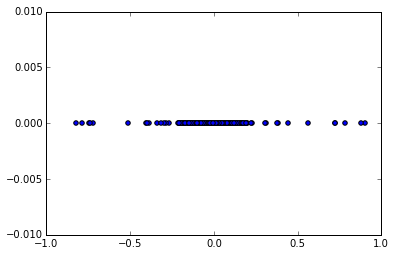

In [69]:
plt.scatter(actual, model_pred_2)

This is horrible.

I don't know why this model doesn't generalize well. When trained on the 25nt randomized data it definitely overfits, but when trained on the genomic data it...underfits? Why? I don't really know... Maybe there isn't enough signal to extract?

Okay, so what if we mix the two types of data? What if we combine genomic and randomized data and trained them together? That *might* work better??? I really have no idea anymore.